## Executive Summary
In this notebook, we will be building a variation of LSTM model for forecasting of future prices
### Content
- [Simple LSTM model](#Simple-LSTM-model)
- [Encoder-Decoder LSTM model Single Output](#Encoder-Decoder-LSTM-model-Single-Output)
- [Sequence to Sequence Prediction](#Sequence-to-Sequence-Prediction)
- [Sequence to Sequence Prediction (With Attention Layer)](#Sequence-to-Sequence-Prediction-(With-Attention-Layer))
- [Sequence to Sequence and Signal Prediction](Sequenceto-Sequence-and-Signal-Prediction)

In [2]:
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
!wget $url/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget $url/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

Selecting previously unselected package libta-lib0.
(Reading database ... 160690 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 276kB 5.3MB/s 
  Created wheel for ta-lib: filename=TA_Lib-0.4.19-cp37-cp37m-linux_x86_64.whl size=1437997 sha256=b34f55d31f4bc06e3eb4b022367c58ac9ba8a7b549704172744a95cb158fe6c1
  Stored in directory: /root/.cache/pip/wheels/a3/f6/12/3d1ccd06caadd8fa47e016991dd0d27f1163bb260f1854e2ff
Successfully built ta-lib


In [3]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 4.1MB/s 


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import talib as ta
import tensorflow as tf
import kerastuner as kt

from statsmodels.graphics.tsaplots import plot_pacf

from kerastuner.engine.hyperparameters import HyperParameters
from kerastuner.tuners import RandomSearch, Hyperband

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix

from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, Attention, RepeatVector, TimeDistributed, BatchNormalization, dot, Concatenate, Activation
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam

sns.set()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  0


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
stock=pd.read_csv('/content/drive/MyDrive/aapl_wmb.csv',parse_dates=['Date'])

In [20]:
aapl=stock[stock['ticker']=='AAPL']

In [22]:
aapl.set_index('Date',inplace=True)
aapl.drop(columns=['ticker'],inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


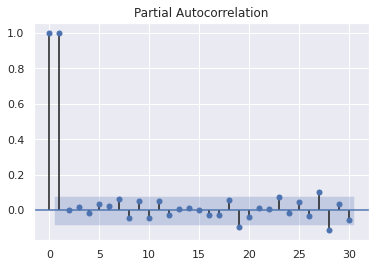

In [42]:
plot_pacf(aapl['Close'],lags=30);
plt.savefig('/content/drive/MyDrive/image/pacf')

In [24]:
aapl['target']=aapl['Close'].shift(-1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [25]:
#We will be focusing on training the model based on 2 years of data due to limited processing capability
aapl=aapl[aapl.index.year>2018]

In [26]:
#These features were dropped after multiple iteration and did not provide model with any additional improvement in prediction
aapl.drop(columns=['Open','High','Low','Volume','Adj Close'],inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [27]:
aapl.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [28]:
X=aapl.drop(columns=['target'])
y=aapl[['target']]

In [29]:
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.9,shuffle=False)

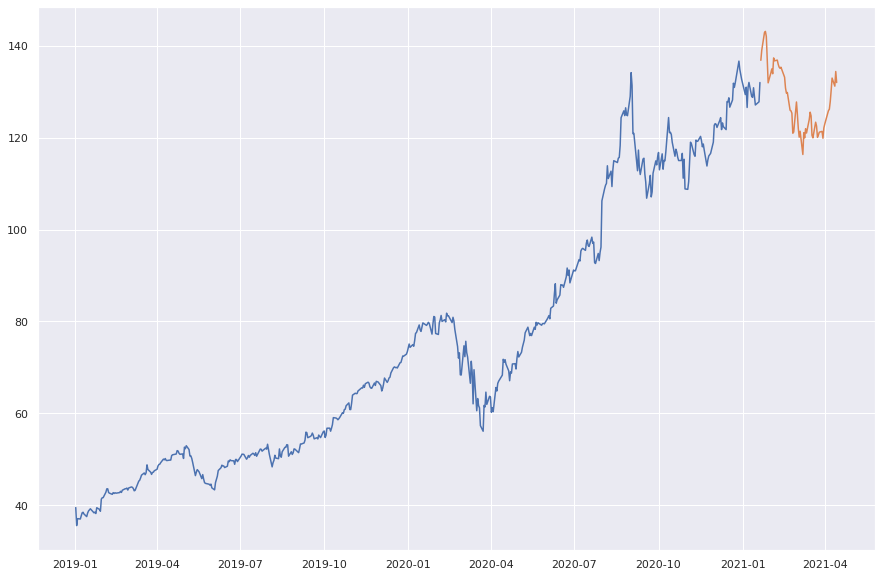

In [30]:
plt.figure(figsize=(15,10))
plt.plot(X_train['Close'])
plt.plot(X_test['Close'])

In [31]:
ss=StandardScaler()
X_train_sc=ss.fit_transform(X_train)
X_test_sc=ss.transform(X_test)

In [32]:
input_len=7

In [33]:
train_sequences=TimeseriesGenerator(X_train_sc,y_train.values,length=input_len,batch_size=64)
test_sequences=TimeseriesGenerator(X_test_sc,y_test.values,length=input_len,batch_size=64)

## Simple LSTM model

We will first start off with 

In [34]:
model=Sequential()

model.add(Bidirectional(LSTM(
    64,
    return_sequences=True),
    input_shape=(input_len,X_train_sc.shape[1])
))

model.add(Bidirectional(LSTM(32)))

model.add(Dense(
    16,
    activation='relu'
))

model.add(Dense(
    8,
    activation='relu'
))

model.add(Dense(1))

model.compile(
    loss='mse',
    optimizer='adam',
    metrics=['mae']
)

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 7, 128)            33792     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 76,193
Trainable params: 76,193
Non-trainable params: 0
_________________________________________________________________


In [35]:
checkpoint_file='/content/drive/MyDrive/simple_lstm'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_file,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [36]:
early_stop=EarlyStopping(monitor='val_loss',min_delta=0,patience=20)

In [25]:
history = model.fit_generator(
    train_sequences,
    validation_data=test_sequences,
    epochs=300,
    verbose=1,
    callbacks=[checkpoint_callback,early_stop]
)

Epoch 1/300
4/8 [==============>...............] - ETA: 0s - loss: 6192.1055 - mae: 72.4605

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


8/8 [==============================] - 2s 263ms/step - loss: 6485.2173 - mae: 75.5102 - val_loss: 15796.3828 - val_mae: 125.5471
Epoch 2/300
8/8 [==============================] - 0s 37ms/step - loss: 6421.8862 - mae: 75.1883 - val_loss: 15425.9951 - val_mae: 124.0665
Epoch 3/300
8/8 [==============================] - 0s 34ms/step - loss: 6289.9243 - mae: 74.5513 - val_loss: 14979.6484 - val_mae: 122.2564
Epoch 4/300
8/8 [==============================] - 0s 30ms/step - loss: 6104.5439 - mae: 73.6265 - val_loss: 14349.3516 - val_mae: 119.6501
Epoch 5/300
8/8 [==============================] - 0s 30ms/step - loss: 5940.7383 - mae: 72.7159 - val_loss: 13481.4893 - val_mae: 115.9631
Epoch 6/300
8/8 [==============================] - 0s 29ms/step - loss: 5600.7334 - mae: 70.8628 - val_loss: 12717.9912 - val_mae: 112.6212
Epoch 7/300
8/8 [==============================] - 0s 31ms/step - loss: 5199.0171 - mae: 68.4332 - val_loss: 12001.4648 - val_mae: 109.3923
Epoch 8/300
8/8 [==============

In [37]:
model.load_weights('/content/drive/MyDrive/simple_lstm')

In [38]:
predict=pd.DataFrame(model.predict_generator(test_sequences),index=y_test.index[input_len:],columns=['predict'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [39]:
train_predict=pd.DataFrame(model.predict_generator(train_sequences),index=y_train.index[input_len:],columns=['predict'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


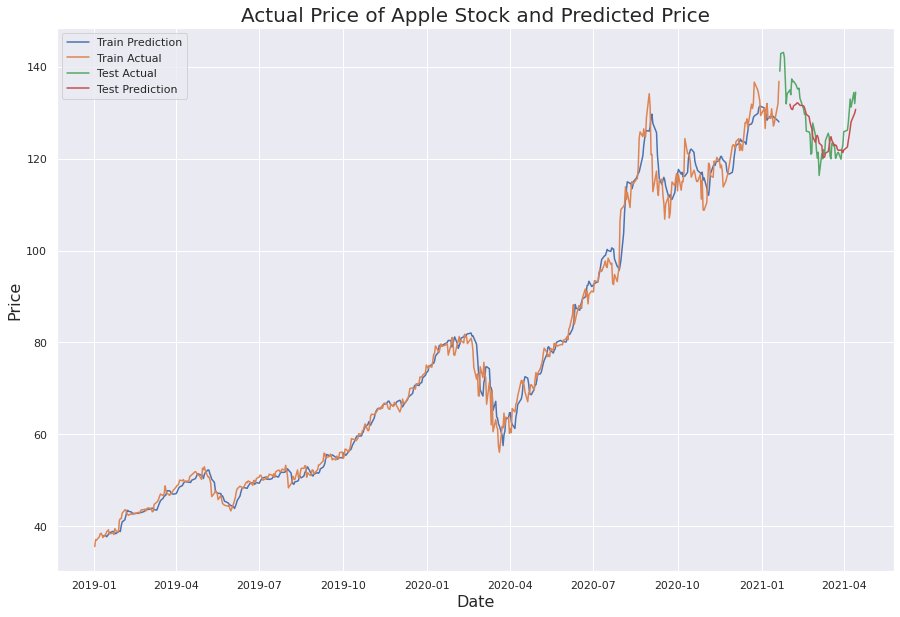

In [41]:
plt.figure(figsize=(15,10))
plt.plot(train_predict, label='Train Prediction')
plt.plot(y_train, label='Train Actual')
plt.plot(y_test, label='Test Actual')
plt.plot(predict, label='Test Prediction')
plt.legend(loc='upper left')
plt.xlabel('Date',fontsize=16)
plt.ylabel('Price',fontsize=16)
plt.title('Actual Price of Apple Stock and Predicted Price',size=20);
plt.savefig('/content/drive/MyDrive/image/simple')

From the simple LSTM, we can tell that the training data has been fitted well but there are lack in prediction capability for unseen data

## Encoder-Decoder LSTM Model Single Output

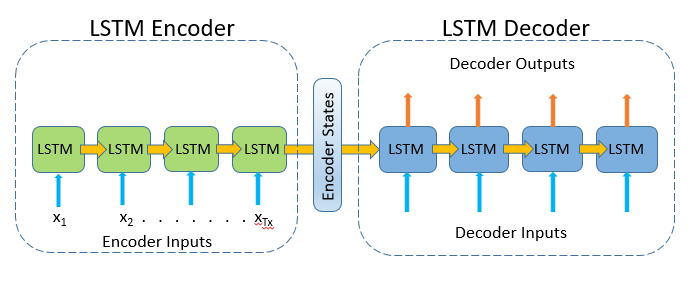

Encoder layer consist of several LSTM layer and the final encoder will return an encoder state which aim to encapsulate the information of all the input elements. This encoder states will be serve as the input for the Decoder layer which also consist of servel LSTM layer.

In [43]:
model_en=Sequential()

model_en.add(Bidirectional(LSTM(
    64,
    return_sequences=True),
    input_shape=(input_len,X_train_sc.shape[1])
))

model_en.add(Bidirectional(LSTM(32)))

model_en.add(Dense(
    16,
    activation='relu'
))

model_en.add(RepeatVector(1))

model_en.add(Bidirectional(LSTM(32,return_sequences=True)))

model_en.add(Bidirectional(LSTM(64, activation='relu')))

model_en.add(Dense(1))

model_en.compile(
    loss='mse',
    optimizer=Adam(0.01),
    metrics=['mae']
)

In [31]:
checkpoint_file='/content/drive/MyDrive/en_lstm'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_file,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [32]:
history_en = model_en.fit_generator(
    train_sequences,
    validation_data=test_sequences,
    epochs=1000,
    verbose=1,
    callbacks=[checkpoint_callback]
)
model_en.save('/content/drive/MyDrive/en_model')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/1000
8/8 [==============================] - 14s 403ms/step - loss: 7451.0343 - mae: 82.5046 - val_loss: 14915.6680 - val_mae: 121.9859
Epoch 2/1000
8/8 [==============================] - 0s 29ms/step - loss: 2656.0775 - mae: 49.8867 - val_loss: 4839.9951 - val_mae: 69.3171
Epoch 3/1000
8/8 [==============================] - 0s 33ms/step - loss: 1458.7148 - mae: 33.0423 - val_loss: 426.6599 - val_mae: 19.7855
Epoch 4/1000
8/8 [==============================] - 0s 29ms/step - loss: 446.3970 - mae: 17.7925 - val_loss: 444.9349 - val_mae: 20.2418
Epoch 5/1000
8/8 [==============================] - 0s 29ms/step - loss: 177.5789 - mae: 10.2825 - val_loss: 134.9645 - val_mae: 10.0054
Epoch 6/1000
8/8 [==============================] - 0s 32ms/step - loss: 177.7639 - mae: 11.6596 - val_loss: 86.1412 - val_mae: 7.2662
Epoch 7/1000
8/8 [==============================] - 0s 30ms/step - loss: 228.7910 - mae: 12.7867 - val_loss: 345.8566 - val_mae: 17.6252
Epoch 8/1000
8/8 [================

INFO:tensorflow:Assets written to: /content/drive/MyDrive/en_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/en_model/assets


In [44]:
model_en.load_weights('/content/drive/MyDrive/en_lstm')

In [45]:
predict_en=pd.DataFrame(model_en.predict_generator(test_sequences),index=y_test.index[input_len:],columns=['predict'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [46]:
train_predict_en=pd.DataFrame(model_en.predict_generator(train_sequences),index=y_train.index[input_len:],columns=['predict'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


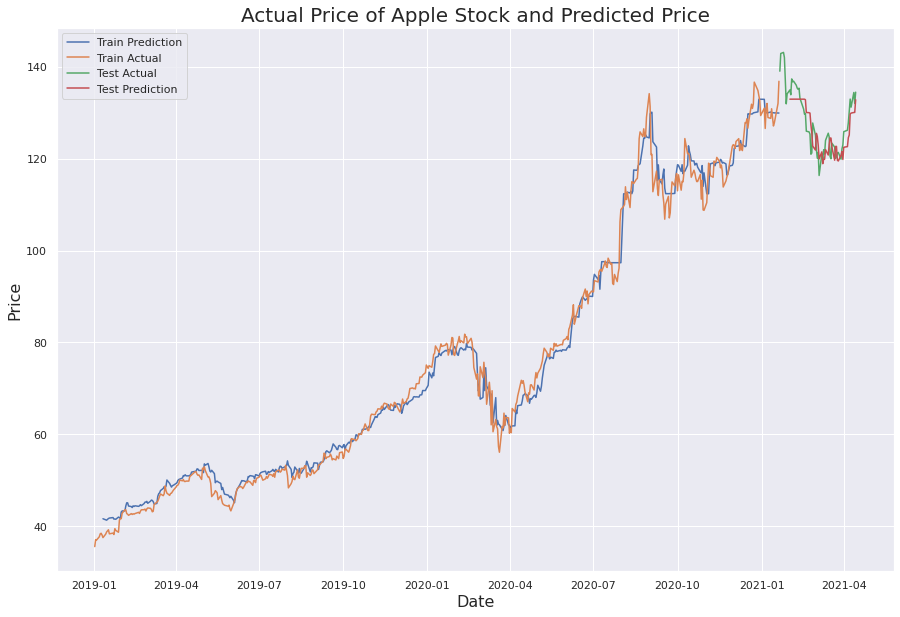

In [47]:
plt.figure(figsize=(15,10))
plt.plot(train_predict_en, label='Train Prediction')
plt.plot(y_train, label='Train Actual')
plt.plot(y_test, label='Test Actual')
plt.plot(predict_en, label='Test Prediction')
plt.legend(loc='upper left')
plt.xlabel('Date',fontsize=16)
plt.ylabel('Price',fontsize=16)
plt.title('Actual Price of Apple Stock and Predicted Price',size=20)
plt.savefig('/content/drive/MyDrive/image/en');

From the graph above, it can be seen that the test prediction is better and we will be using this architecture for sequence to sequence prediction

## Sequence to Sequence Prediction

In [48]:
def sequence_generator(X, y, in_len,out_len):
  X_seq=np.array([])
  for i in range(len(X)-in_len-out_len):
    X_seq=np.append(X_seq,X[i:i+in_len])
  X_seq=X_seq.reshape(len(X)-in_len-out_len,in_len,X.shape[1])

  y_seq=np.array([])
  for i in range(len(X)-in_len-out_len):
    y_seq=np.append(y_seq,y.values[in_len+i-1:i+out_len+in_len-1])
  y_seq=y_seq.reshape(len(X)-in_len-out_len,out_len,y.shape[1])

  return X_seq, y_seq

In [49]:
output_len=7

In [50]:
X_train_seq,y_train_seq=sequence_generator(X_train,y_train,input_len,output_len)

In [51]:
#Comparing the past 7 days data to confirm that it's the same as the pridicted 7 days data
X_train_seq[7]

array([[38.07249832],
       [37.5       ],
       [38.26750183],
       [38.73500061],
       [38.96500015],
       [39.20500183],
       [38.32500076]])

In [52]:
y_train_seq[0]

array([[38.07249832],
       [37.5       ],
       [38.26750183],
       [38.73500061],
       [38.96500015],
       [39.20500183],
       [38.32500076]])

In [53]:
X_test_seq,y_test_seq=sequence_generator(X_test,y_test,input_len,output_len)

In [54]:
model_seq=Sequential()

model_seq.add(Bidirectional(LSTM(
    64,
    return_sequences=True),
    input_shape=(X_train_seq.shape[1],X_train_seq.shape[2])
))

model_seq.add(Bidirectional(LSTM(32)))

model_seq.add(Dense(
    16,
    activation='relu'
))

model_seq.add(RepeatVector(y_train_seq.shape[1]))

model_seq.add(Bidirectional(LSTM(32,return_sequences=True)))

model_seq.add(Bidirectional(LSTM(64,return_sequences=True, activation='relu')))

model_seq.add(TimeDistributed(Dense(1)))

model_seq.compile(
    loss='mse',
    optimizer=Adam(0.01),
    metrics=['mae']
)

In [42]:
checkpoint_file='/content/drive/MyDrive/seq_lstm2'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_file,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [71]:
history_en = model_seq.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_test_seq,y_test_seq),
    epochs=1000,
    verbose=1,
    callbacks=[checkpoint_callback]
)
model_seq.save('/content/drive/MyDrive/seq_model')

Epoch 1/1000
16/16 [==============================] - 14s 186ms/step - loss: 4433.2314 - mae: 57.3530 - val_loss: 3877.1086 - val_mae: 60.3062
Epoch 2/1000
16/16 [==============================] - 0s 30ms/step - loss: 835.0062 - mae: 22.1985 - val_loss: 1428.4120 - val_mae: 36.8367
Epoch 3/1000
16/16 [==============================] - 0s 30ms/step - loss: 155.1311 - mae: 8.9737 - val_loss: 94.7169 - val_mae: 8.3213
Epoch 4/1000
16/16 [==============================] - 1s 32ms/step - loss: 31.6452 - mae: 4.3208 - val_loss: 39.2455 - val_mae: 4.7298
Epoch 5/1000
16/16 [==============================] - 0s 31ms/step - loss: 25.9993 - mae: 3.8256 - val_loss: 51.5434 - val_mae: 5.4856
Epoch 6/1000
16/16 [==============================] - 0s 30ms/step - loss: 19.0670 - mae: 3.1812 - val_loss: 66.6357 - val_mae: 6.8716
Epoch 7/1000
16/16 [==============================] - 0s 31ms/step - loss: 21.7690 - mae: 3.4008 - val_loss: 25.0847 - val_mae: 4.2316
Epoch 8/1000
16/16 [=====================

INFO:tensorflow:Assets written to: /content/drive/MyDrive/seq_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/seq_model/assets


In [127]:
model_seq=load_model('/content/drive/MyDrive/seq_model')

In [55]:
model_seq.load_weights('/content/drive/MyDrive/seq_lstm2')

In [56]:
X_val=np.array([])
for i in range(len(X_test)-7):
  X_val=np.append(X_val,X_test[i:i+7])
X_val=X_val.reshape(len(X_test)-7,7,X_test.shape[1])

In [57]:
col=['close'+str(i) for i in range(1,8)]

In [58]:
predict_seq=pd.DataFrame(model_seq.predict(X_val).reshape(-1,7),index=y_test.index[input_len:],columns=col)

In [59]:
train_predict_seq=pd.DataFrame(model_seq.predict(X_train_seq).reshape(-1,7),index=y_train.index[input_len:-output_len],columns=col)

In [60]:
predict_seq['vol']=predict_seq.apply(np.std,axis=1)

In [61]:
predict_seq

close1      close2  ...      close7       vol
Date                                ...                      
2021-02-01  129.113220  129.160843  ...  129.161331  0.016694
2021-02-02  129.823471  129.852432  ...  129.852692  0.010150
2021-02-03  130.983047  131.004318  ...  131.004364  0.007446
2021-02-04  130.941040  130.962265  ...  130.962326  0.007431
2021-02-05  130.680237  130.704376  ...  130.704468  0.008452
2021-02-08  131.049408  131.070496  ...  131.070557  0.007383
2021-02-09  131.029205  131.050293  ...  131.050354  0.007383
2021-02-10  130.811447  130.834534  ...  130.834595  0.008082
2021-02-11  130.926941  130.948624  ...  130.948685  0.007591
2021-02-12  130.851471  130.873657  ...  130.873718  0.007767
2021-02-16  130.923172  130.944824  ...  130.944885  0.007580
2021-02-17  130.497269  130.521576  ...  130.521683  0.008512
2021-02-18  128.192474  128.275070  ...  128.276215  0.028972
2021-02-19  127.240799  127.398041  ...  127.400566  0.055177
2021-02-22  128.077484  128.164398  ...  128.165680  0.030492
2021-02-23  124.167496  124.568756  ...  124.867462  0.188503
2021-02-24  124.073532  124.477844  ...  124.844620  0.206256
2021-02-25  124.117584  124.522430  ...  124.879974  0.204037
2021-02-26  120.409431  120.986885  ...  121.600327  0.318384
2021-03-01  122.380783  122.839874  ...  123.251160  0.232868
2021-03-02  125.765961  126.100731  ...  126.106880  0.117523
2021-03-03  123.916046  124.328400  ...  124.752151  0.223473
2021-03-04  122.504669  122.962631  ...  123.374992  0.232832
2021-03-05  122.186661  122.670792  ...  123.078232  0.238911
2021-03-08  121.812576  122.303001  ...  122.720245  0.243147
2021-03-09  119.482758  120.088737  ...  120.805794  0.354485
2021-03-10  122.329361  122.768616  ...  123.187424  0.229373
2021-03-11  120.980667  121.538437  ...  122.004227  0.274346
2021-03-12  122.459229  122.950584  ...  123.365898  0.242926
2021-03-15  122.458504  122.923828  ...  123.335030  0.234580
2021-03-16  123.706467  124.117180  ...  124.575729  0.232571
2021-03-17  124.177673  124.583206  ...  124.923065  0.199766
2021-03-18  124.041489  124.448349  ...  124.897614  0.229009
2021-03-19  121.576508  122.105431  ...  122.513992  0.252024
2021-03-22  122.180283  122.658173  ...  123.067764  0.237691
2021-03-23  123.221268  123.641830  ...  124.073143  0.227686
2021-03-24  121.571350  122.088211  ...  122.506424  0.250900
2021-03-25  121.892319  122.398788  ...  122.804611  0.244878
2021-03-26  122.788696  123.230331  ...  123.650131  0.230281
2021-03-29  122.098709  122.578842  ...  122.989540  0.238601
2021-03-30  122.227287  122.700912  ...  123.110855  0.236581
2021-03-31  122.092453  122.583939  ...  122.990509  0.240781
2021-04-01  123.013367  123.440727  ...  123.868134  0.228446
2021-04-05  122.944199  123.379509  ...  123.804169  0.229849
2021-04-06  124.430916  124.835678  ...  124.979874  0.158080
2021-04-07  124.410042  124.815163  ...  124.972572  0.160417
2021-04-08  125.546127  125.913940  ...  125.919922  0.129073
2021-04-09  127.223083  127.411133  ...  127.412682  0.065896
2021-04-12  129.458771  129.505630  ...  129.505936  0.016416
2021-04-13  128.149643  128.256012  ...  128.256912  0.037275
2021-04-14  128.905426  128.964020  ...  128.964584  0.020537

[51 rows x 8 columns]

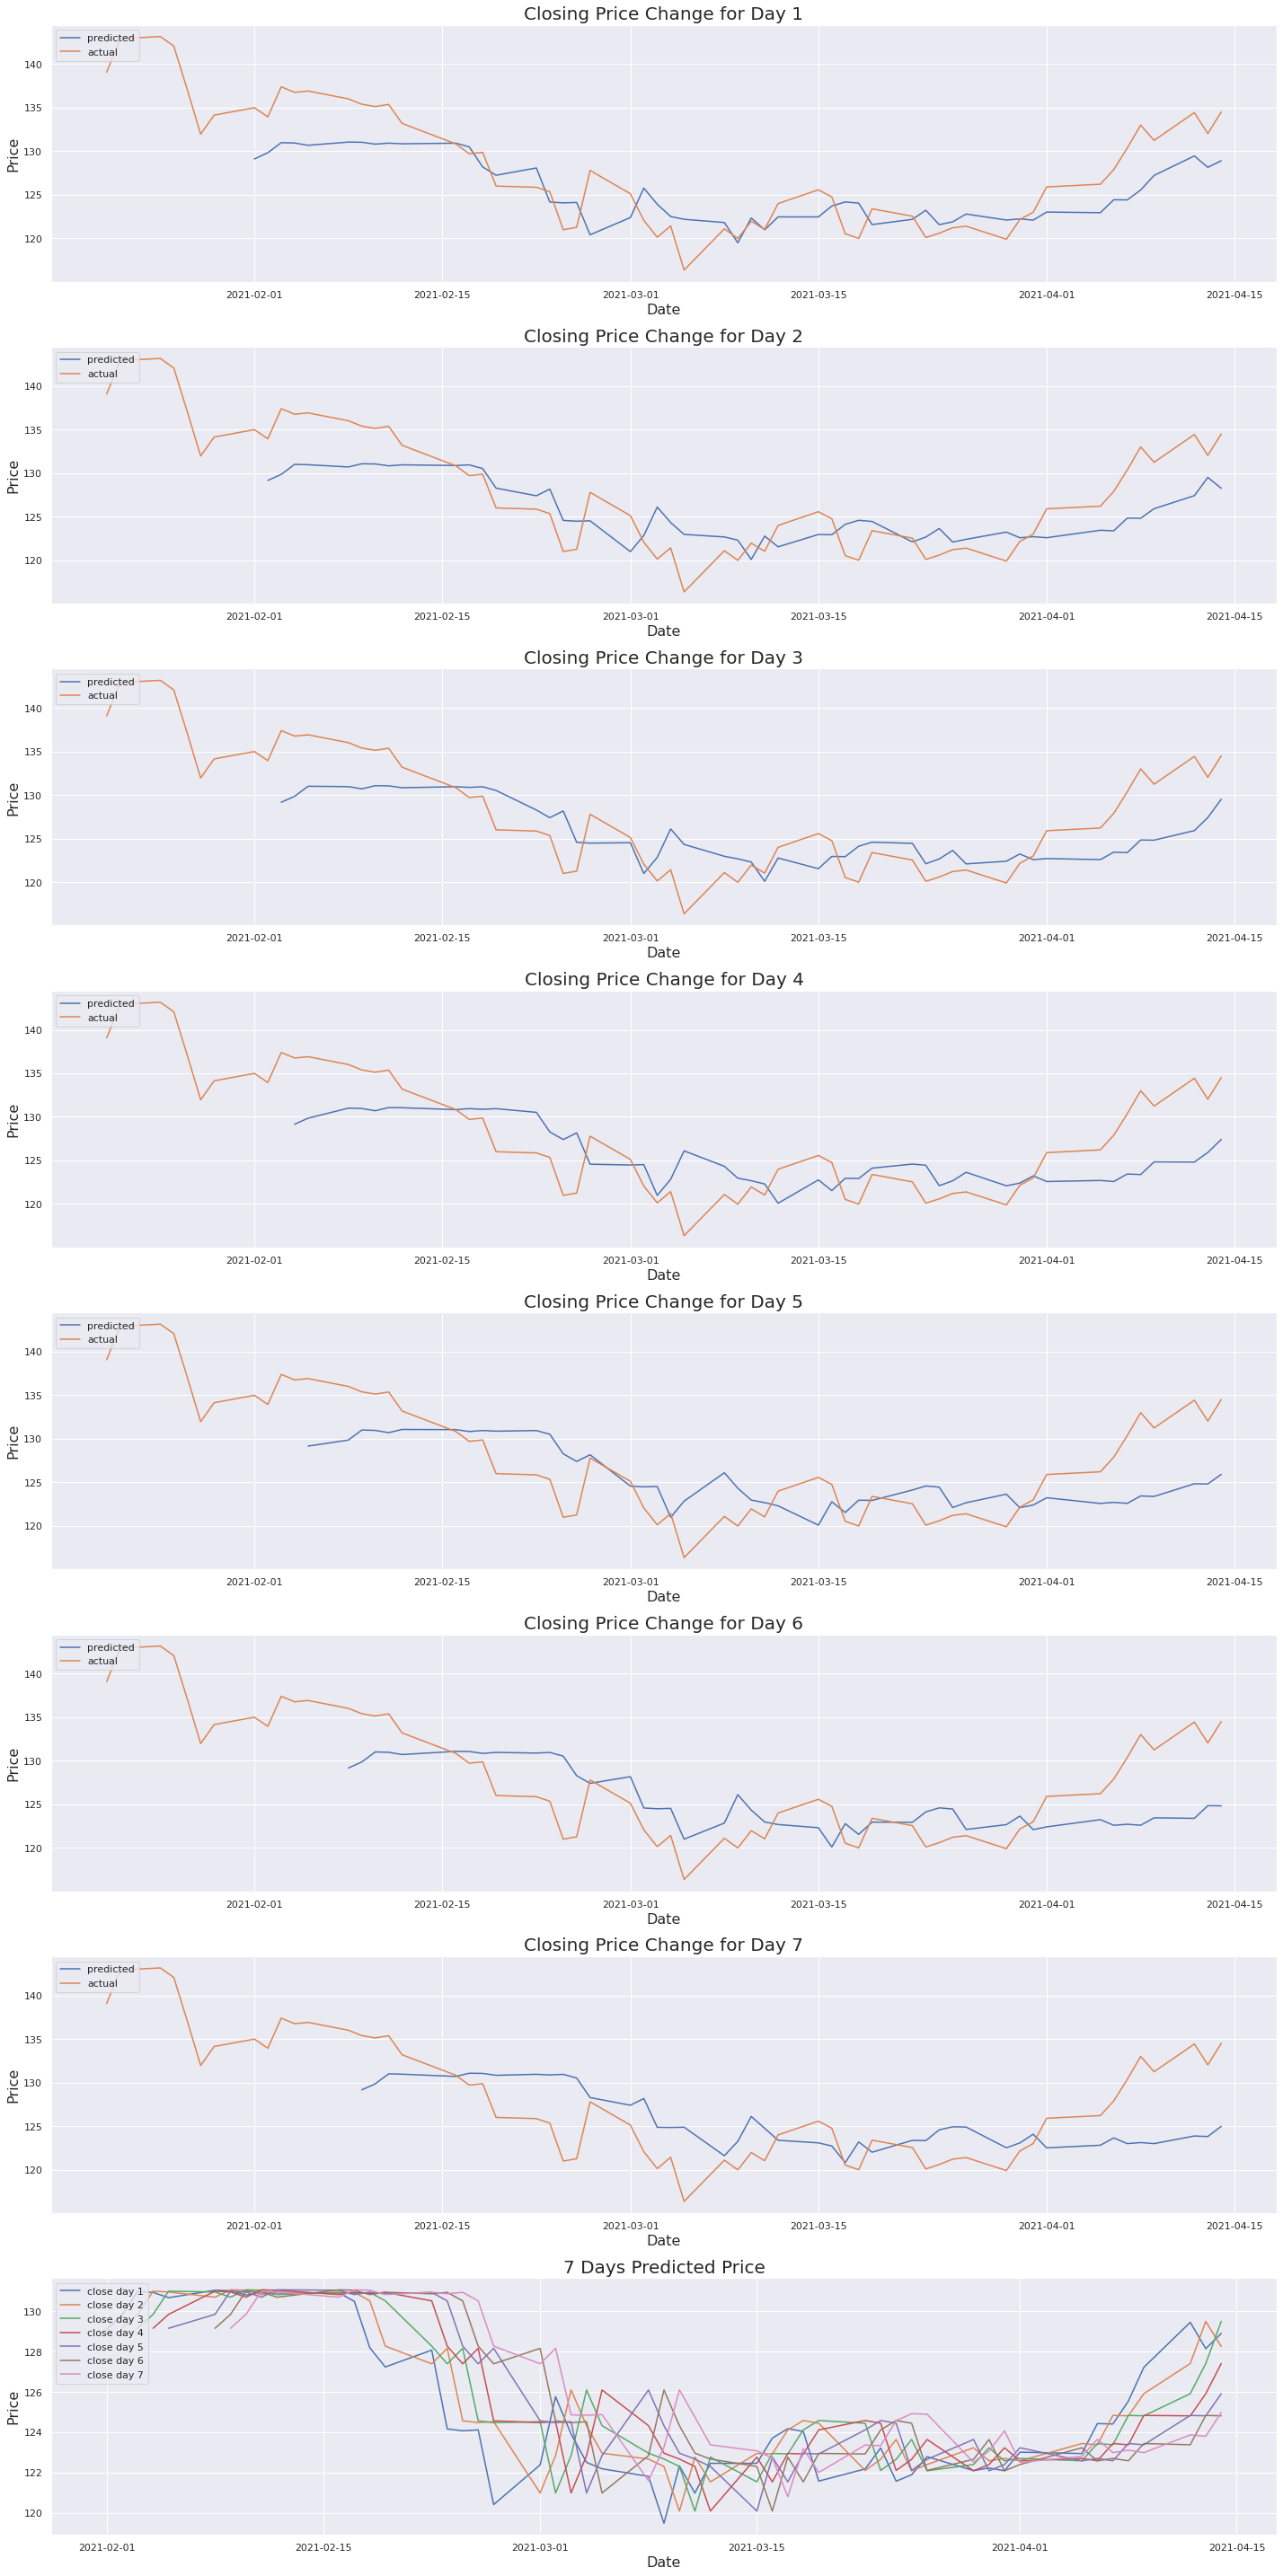

In [62]:
fig,axes=plt.subplots(8,1,figsize=(20,40))

for i in range(0,7):
  axes[7].plot(predict_seq['close'+str(i+1)].shift(i),label='close day '+str(i+1))
  axes[7].set_xlabel('Date',size=16)
  axes[7].set_ylabel('Price',size=16)
  axes[7].set_title('7 Days Predicted Price',size=20)
  axes[7].legend(loc='upper left')

for i in range(0,7):
  axes[i].plot(predict_seq['close'+str(i+1)].shift(i),label='predicted')
  axes[i].plot(y_test,label='actual')
  axes[i].set_title('Closing Price Change for Day '+str(i+1),size=20)
  axes[i].set_xlabel('Date',size=16)
  axes[i].set_ylabel('Price',size=16)
  axes[i].legend(loc='upper left')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/image/seq_7')

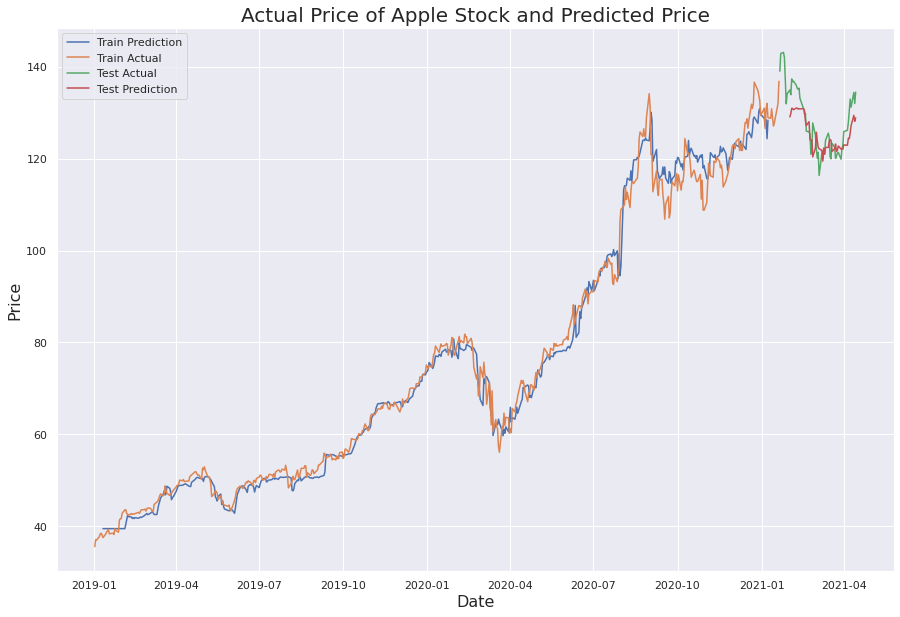

In [63]:
plt.figure(figsize=(15,10))
plt.plot(train_predict_seq['close1'],label='Train Prediction')
plt.plot(y_train, label='Train Actual')
plt.plot(y_test, label='Test Actual')
plt.plot(predict_seq['close1'], label='Test Prediction')
plt.legend(loc='upper left')
plt.xlabel('Date',fontsize=16)
plt.ylabel('Price',fontsize=16)
plt.title('Actual Price of Apple Stock and Predicted Price',size=20);
plt.savefig('/content/drive/MyDrive/image/seq')

From the graph above, it can be seen that despite that the next day prediction of the price is relatively accurate, the subsequence day prediction is generally just following the day 1 prediction which could be due to the diminishing long term trend

## Sequence to Sequence Prediction (With Attention Layer)

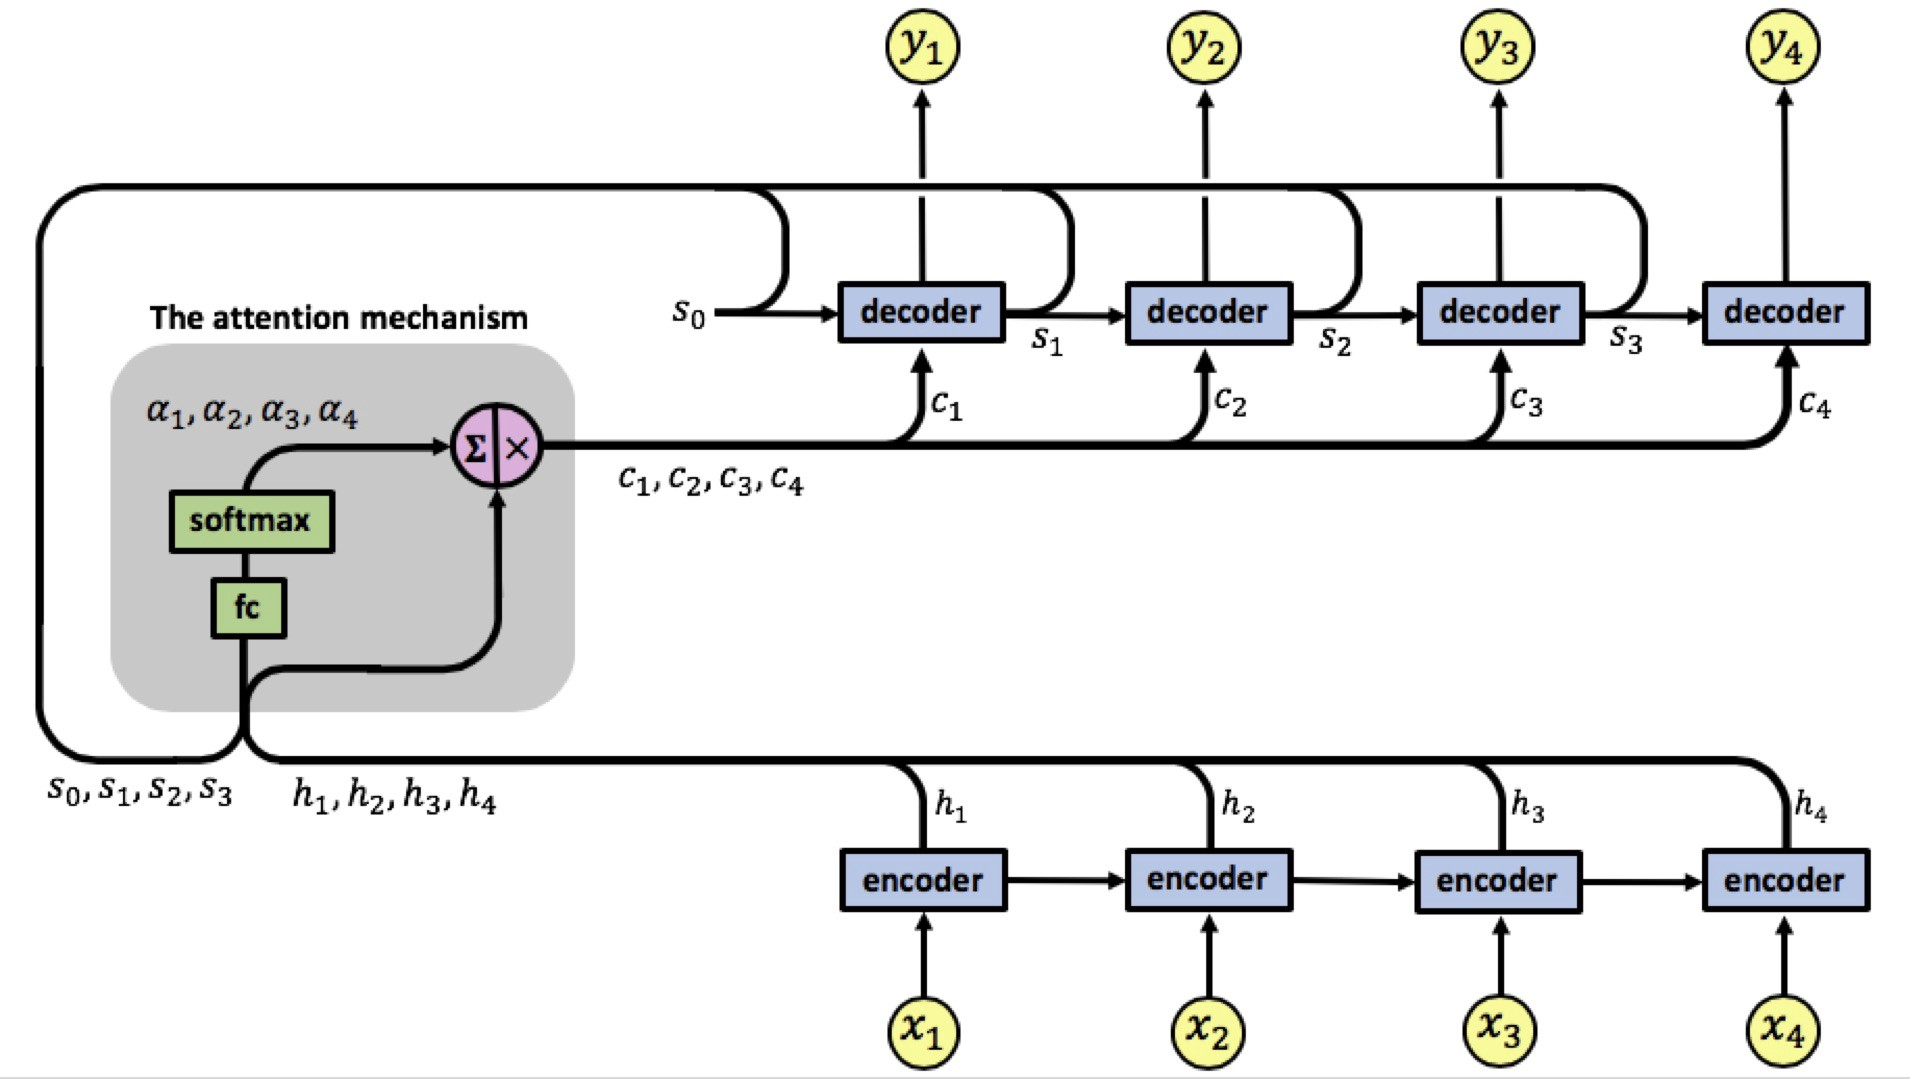

We will now utilize the attention layer so that we are able to better retain long term trend in the data. The attention layer is a layer where a dot product will be perform part of the encoder_state and the decoder_state and a softmax will be perform to find the max important state to be concate with the remaining encoder state to ensure that long term trend will still be kept

In [64]:
input_price = Input(shape=(X_train_seq.shape[1],X_train_seq.shape[2]))

input_lstm= Bidirectional(LSTM(64,return_sequences=True))(input_price)

encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(32,
                                                       return_state=True,
                                                       return_sequences=True
)(input_lstm)

hidden= Dense(16,activation='relu')(encoder_last_h)

decoder_input = RepeatVector(y_train_seq.shape[1])(hidden)

decoder_stack_h = LSTM(
    32,
    return_sequences=True
)(decoder_input, initial_state=[encoder_last_h,encoder_last_c])

atten = Attention()([decoder_stack_h,encoder_stack_h])

lstm_decoder=Bidirectional(LSTM(
    64,
    return_sequences=True
))(atten)

out = TimeDistributed(Dense(1))(lstm_decoder)

model_atten= Model(inputs=input_price,outputs=out)

model_atten.compile(
    loss='mse',
    optimizer=Adam(0.01),
    metrics=['mae']
)

In [65]:
checkpoint_file='/content/drive/MyDrive/atten_lstm'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_file,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [66]:
model_atten.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 7, 1)]       0                                            
__________________________________________________________________________________________________
bidirectional_10 (Bidirectional (None, 7, 128)       33792       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_11 (LSTM)                  [(None, 7, 32), (Non 20608       bidirectional_10[0][0]           
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 16)           528         lstm_11[0][1]                    
______________________________________________________________________________________________

In [163]:
history_atten = model_atten.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_test_seq,y_test_seq),
    epochs=1000,
    verbose=1,
    callbacks=[checkpoint_callback]
)
model_atten.save('/content/drive/MyDrive/atten_model')

Epoch 1/1000
16/16 [==============================] - 0s 30ms/step - loss: 14.3870 - mae: 2.5729 - val_loss: 25.3756 - val_mae: 4.0959
Epoch 2/1000
16/16 [==============================] - 0s 27ms/step - loss: 12.1521 - mae: 2.3799 - val_loss: 29.2805 - val_mae: 4.3652
Epoch 3/1000
16/16 [==============================] - 0s 25ms/step - loss: 11.2157 - mae: 2.2835 - val_loss: 24.2759 - val_mae: 4.1228
Epoch 4/1000
16/16 [==============================] - 0s 26ms/step - loss: 10.5281 - mae: 2.2103 - val_loss: 28.9113 - val_mae: 4.6467
Epoch 5/1000
16/16 [==============================] - 0s 25ms/step - loss: 12.9019 - mae: 2.5738 - val_loss: 26.8275 - val_mae: 4.2354
Epoch 6/1000
16/16 [==============================] - 0s 26ms/step - loss: 11.9805 - mae: 2.3257 - val_loss: 23.2969 - val_mae: 4.0395
Epoch 7/1000
16/16 [==============================] - 0s 25ms/step - loss: 12.1118 - mae: 2.3433 - val_loss: 24.8692 - val_mae: 4.2957
Epoch 8/1000
16/16 [==============================] - 0

INFO:tensorflow:Assets written to: /content/drive/MyDrive/atten_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/atten_model/assets


In [68]:
model_atten.load_weights('/content/drive/MyDrive/atten_lstm')

In [70]:
predict_atten=pd.DataFrame(model_atten.predict(X_val).reshape(-1,7),index=y_test.index[input_len:],columns=col)

In [69]:
train_predict_atten=pd.DataFrame(model_atten.predict(X_train_seq).reshape(-1,7),index=y_train.index[input_len:-output_len],columns=col)

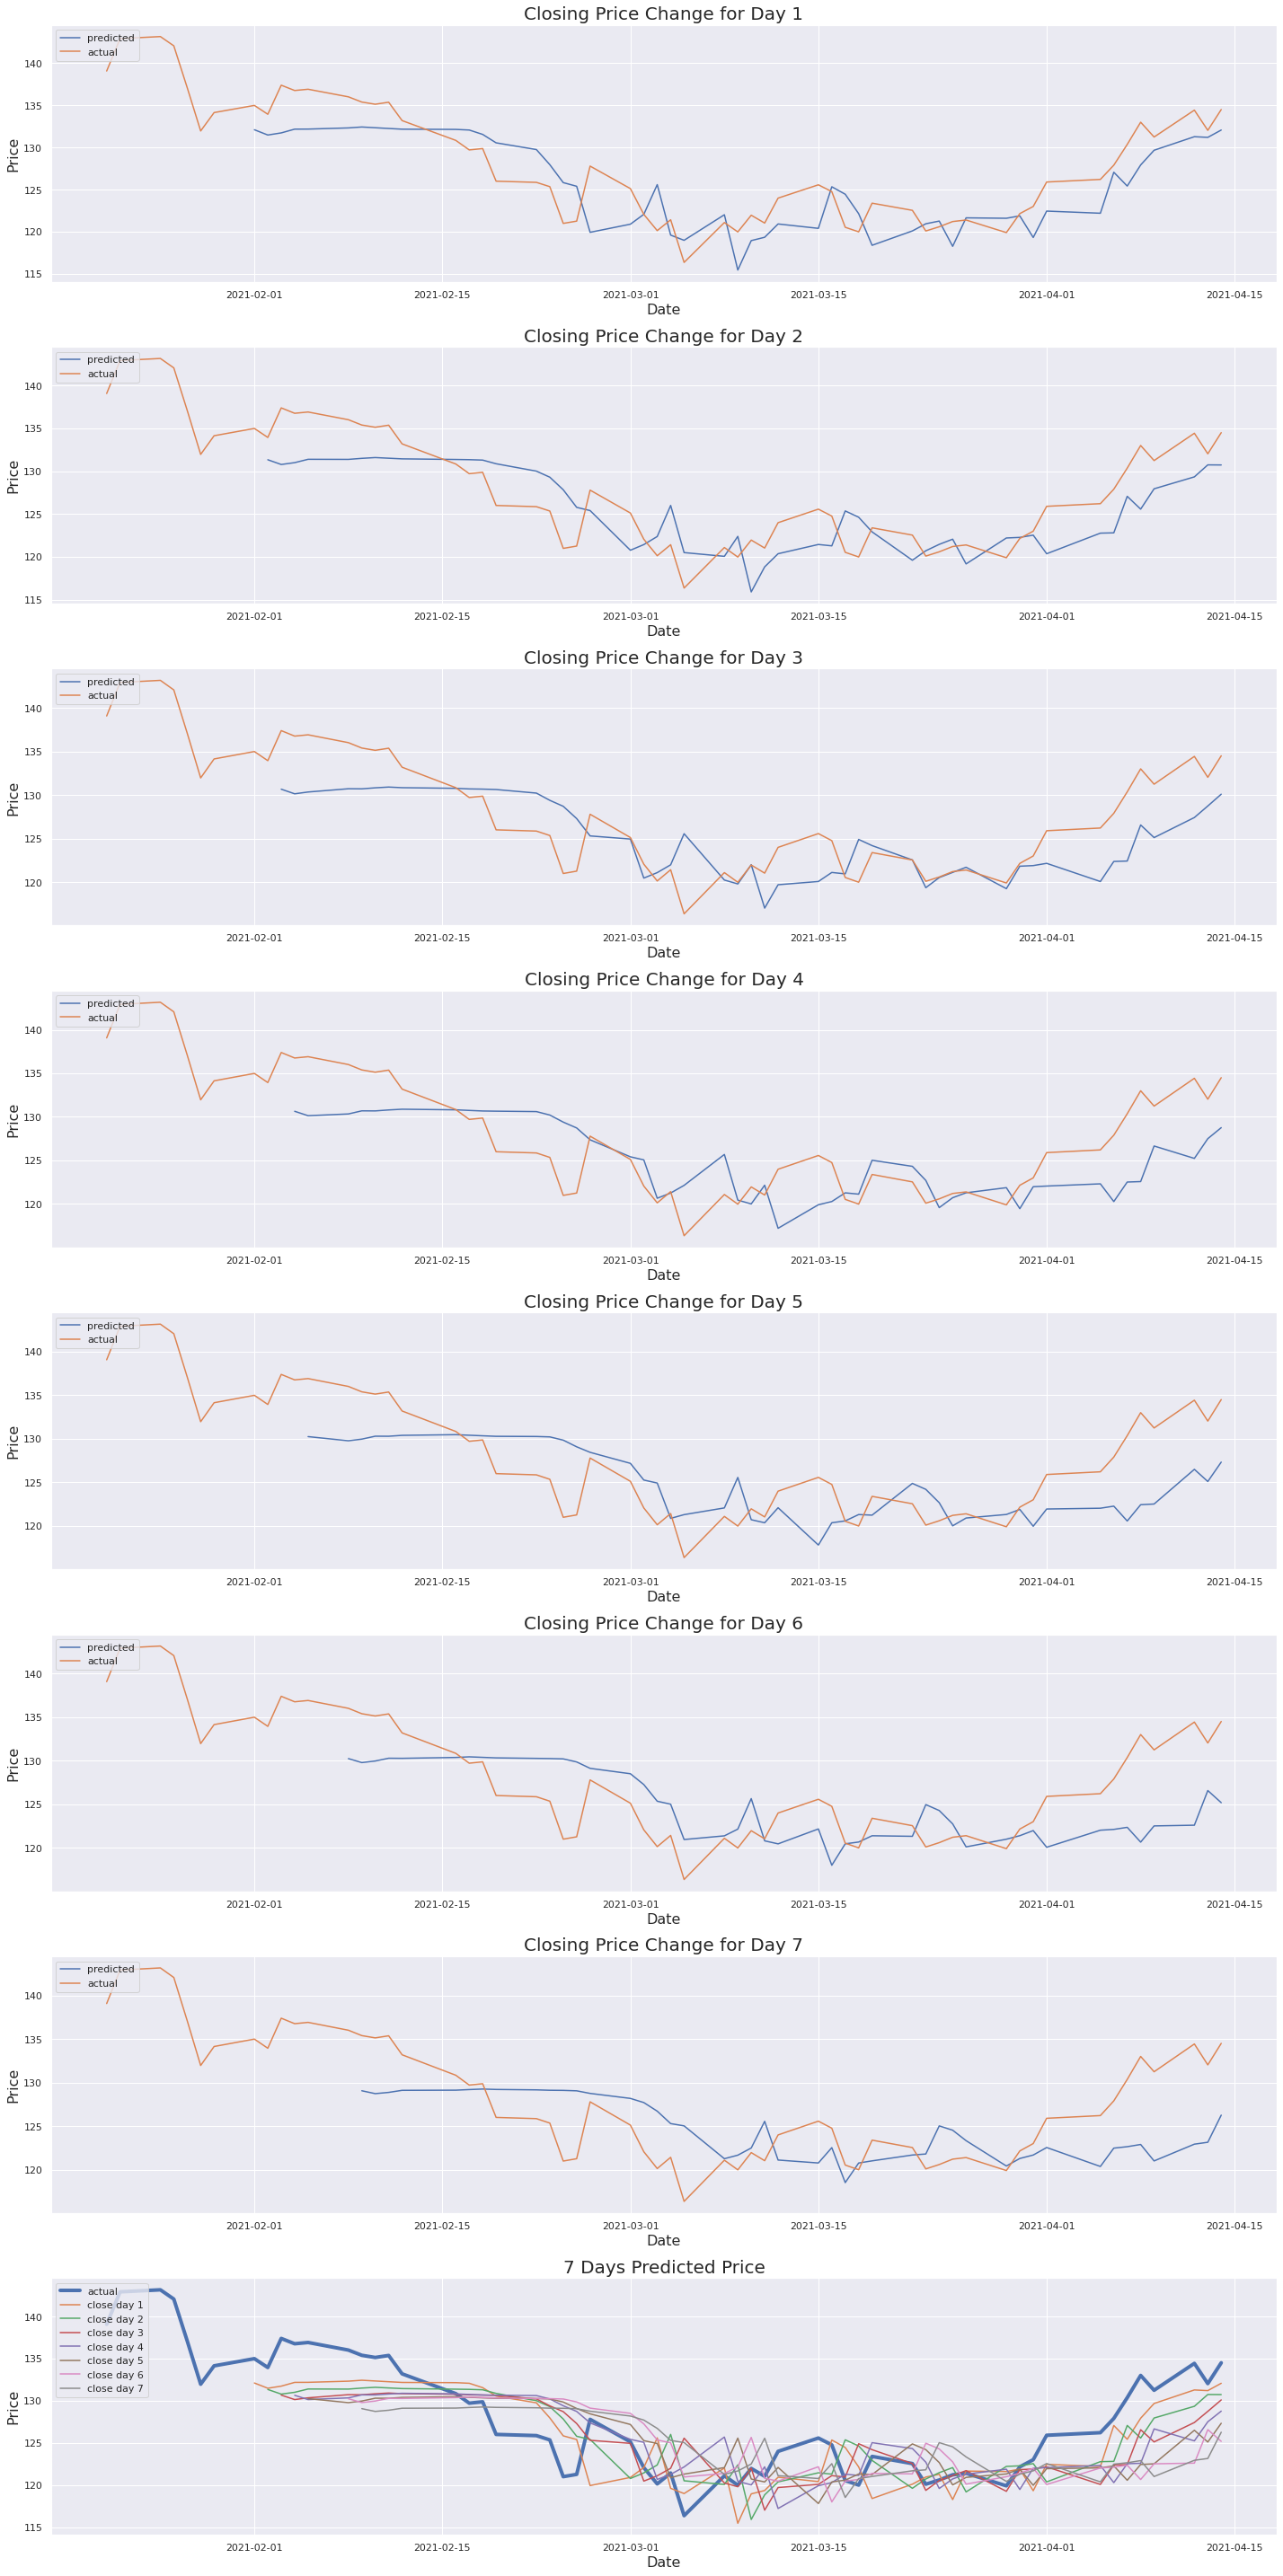

In [93]:
fig,axes=plt.subplots(8,1,figsize=(20,40))

axes[7].plot(y_test,label='actual',linewidth=4)
for i in range(0,7):
  axes[7].plot(predict_atten['close'+str(i+1)].shift(i),label='close day '+str(i+1))
  axes[7].set_xlabel('Date',size=16)
  axes[7].set_ylabel('Price',size=16)
  axes[7].set_title('7 Days Predicted Price',size=20)
  axes[7].legend(loc='upper left')

for i in range(0,7):
  axes[i].plot(predict_atten['close'+str(i+1)].shift(i),label='predicted')
  axes[i].plot(y_test,label='actual')
  axes[i].set_title('Closing Price Change for Day '+str(i+1),size=20)
  axes[i].set_xlabel('Date',size=16)
  axes[i].set_ylabel('Price',size=16)
  axes[i].legend(loc='upper left')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/image/atten_7');

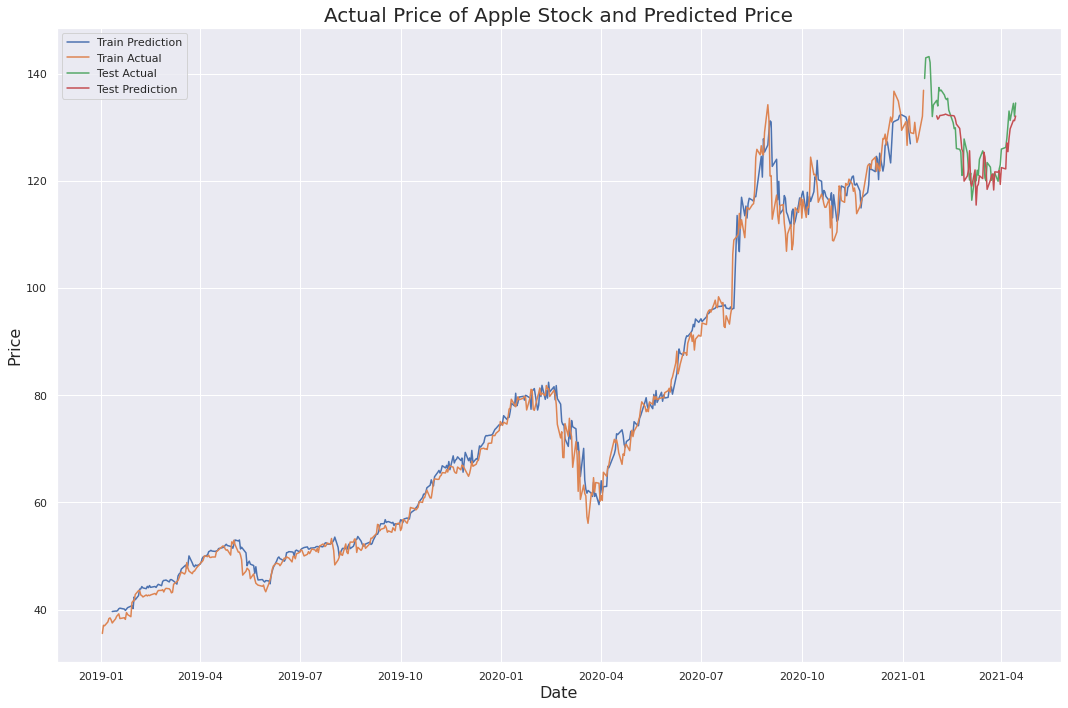

In [73]:
plt.figure(figsize=(15,10))
plt.plot(train_predict_atten['close1'],label='Train Prediction')
plt.plot(y_train,label='Train Actual')
plt.plot(y_test,label='Test Actual')
plt.plot(predict_atten['close1'],label='Test Prediction')
plt.legend(loc='upper left')
plt.xlabel('Date',fontsize=16)
plt.ylabel('Price',fontsize=16)
plt.title('Actual Price of Apple Stock and Predicted Price',size=20)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/image/atten');

## Sequence to Sequence and Signal Prediction

In [74]:
y_buy_train=pd.DataFrame(y_train['target']-X_train['Close'],columns=['signal'])

In [75]:
y_buy_train['signal']=y_buy_train['signal'].map(lambda x: 1 if x>0 else 0)

In [76]:
y_buy_train

signal
Date              
2019-01-02       0
2019-01-03       1
2019-01-04       0
2019-01-07       1
2019-01-08       1
...            ...
2021-01-13       0
2021-01-14       0
2021-01-15       1
2021-01-19       1
2021-01-20       1

[517 rows x 1 columns]

In [77]:
y_buy_test=pd.DataFrame(y_test['target']-X_test['Close'],columns=['signal'])

In [78]:
y_buy_test['signal']=y_buy_test['signal'].map(lambda x: 1 if x>0 else 0)

In [79]:
y_buy_train=y_buy_train.values[7:-7]

In [80]:
y_buy_test=y_buy_test.values[7:-7]

In [81]:
y_buy_test.shape

(44, 1)

In [82]:
input_price = Input(shape=(X_train_seq.shape[1],X_train_seq.shape[2]))

input_lstm= Bidirectional(LSTM(64,return_sequences=True))(input_price)

encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(32,
                                                       return_state=True,
                                                       return_sequences=True
)(input_lstm)

hidden= Dense(16,activation='relu')(encoder_last_h)

decoder_input = RepeatVector(y_train_seq.shape[1])(hidden)

decoder_stack_h = LSTM(
    32,
    return_sequences=True
)(decoder_input, initial_state=[encoder_last_h,encoder_last_c])

atten = Attention()([decoder_stack_h,encoder_stack_h])

lstm_decoder=Bidirectional(LSTM(
    64,
    return_sequences=True
))(atten)

out = TimeDistributed(Dense(1),name='out_price')(lstm_decoder)

buy_in = Bidirectional(LSTM(32))(lstm_decoder)

buy_out = Dense(1, activation='sigmoid',name='out_buy')(buy_in)

model_signal= Model(inputs=input_price,outputs=[out, buy_out])

model_signal.compile(
    loss={'out_price':'mse','out_buy':'binary_crossentropy'},
    loss_weights={'out_price':0.1,'out_buy':10},
    optimizer=Adam(0.01),
    metrics={'out_price':'mae','out_buy':'accuracy'}
)

In [83]:
model_signal.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 7, 1)]       0                                            
__________________________________________________________________________________________________
bidirectional_12 (Bidirectional (None, 7, 128)       33792       input_2[0][0]                    
__________________________________________________________________________________________________
lstm_15 (LSTM)                  [(None, 7, 32), (Non 20608       bidirectional_12[0][0]           
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 16)           528         lstm_15[0][1]                    
____________________________________________________________________________________________

In [84]:
checkpoint_file='/content/drive/MyDrive/atten_lstm_signal'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_file,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [85]:
history_signal = model_signal.fit(
    X_train_seq,
    {'out_price':y_train_seq,'out_buy':y_buy_train},
    validation_data=(X_test_seq,{'out_price':y_test_seq,'out_buy':y_buy_test}),
    epochs=4000,
    verbose=1,
    callbacks=[checkpoint_callback]
)
model_signal.save('/content/drive/MyDrive/atten_model_signal')

Streaming output truncated to the last 5000 lines.
Epoch 1501/4000
16/16 [==============================] - 0s 24ms/step - loss: 8.1037 - out_price_loss: 11.8616 - out_buy_loss: 0.6918 - out_price_mae: 2.3346 - out_buy_accuracy: 0.5349 - val_loss: 9.5016 - val_out_price_loss: 23.9091 - val_out_buy_loss: 0.7111 - val_out_price_mae: 4.1547 - val_out_buy_accuracy: 0.4545
Epoch 1502/4000
16/16 [==============================] - 0s 25ms/step - loss: 8.0971 - out_price_loss: 11.3622 - out_buy_loss: 0.6961 - out_price_mae: 2.3199 - out_buy_accuracy: 0.5195 - val_loss: 9.6687 - val_out_price_loss: 25.6698 - val_out_buy_loss: 0.7102 - val_out_price_mae: 4.1584 - val_out_buy_accuracy: 0.4545
Epoch 1503/4000
16/16 [==============================] - 0s 24ms/step - loss: 8.0434 - out_price_loss: 11.9612 - out_buy_loss: 0.6847 - out_price_mae: 2.3649 - out_buy_accuracy: 0.5546 - val_loss: 9.6300 - val_out_price_loss: 25.1403 - val_out_buy_loss: 0.7116 - val_out_price_mae: 4.2558 - val_out_buy_accura

INFO:tensorflow:Assets written to: /content/drive/MyDrive/atten_model_signal/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/atten_model_signal/assets


In [84]:
model_signal.load_weights('/content/drive/MyDrive/atten_lstm_signal')

In [85]:
predict_signal=pd.DataFrame(model_signal.predict(X_val)[0].reshape(-1,7),index=y_test.index[input_len:],columns=col)

In [86]:
train_predict_signal=pd.DataFrame(model_signal.predict(X_train_seq)[0].reshape(-1,7),index=y_train.index[input_len:-output_len],columns=col)

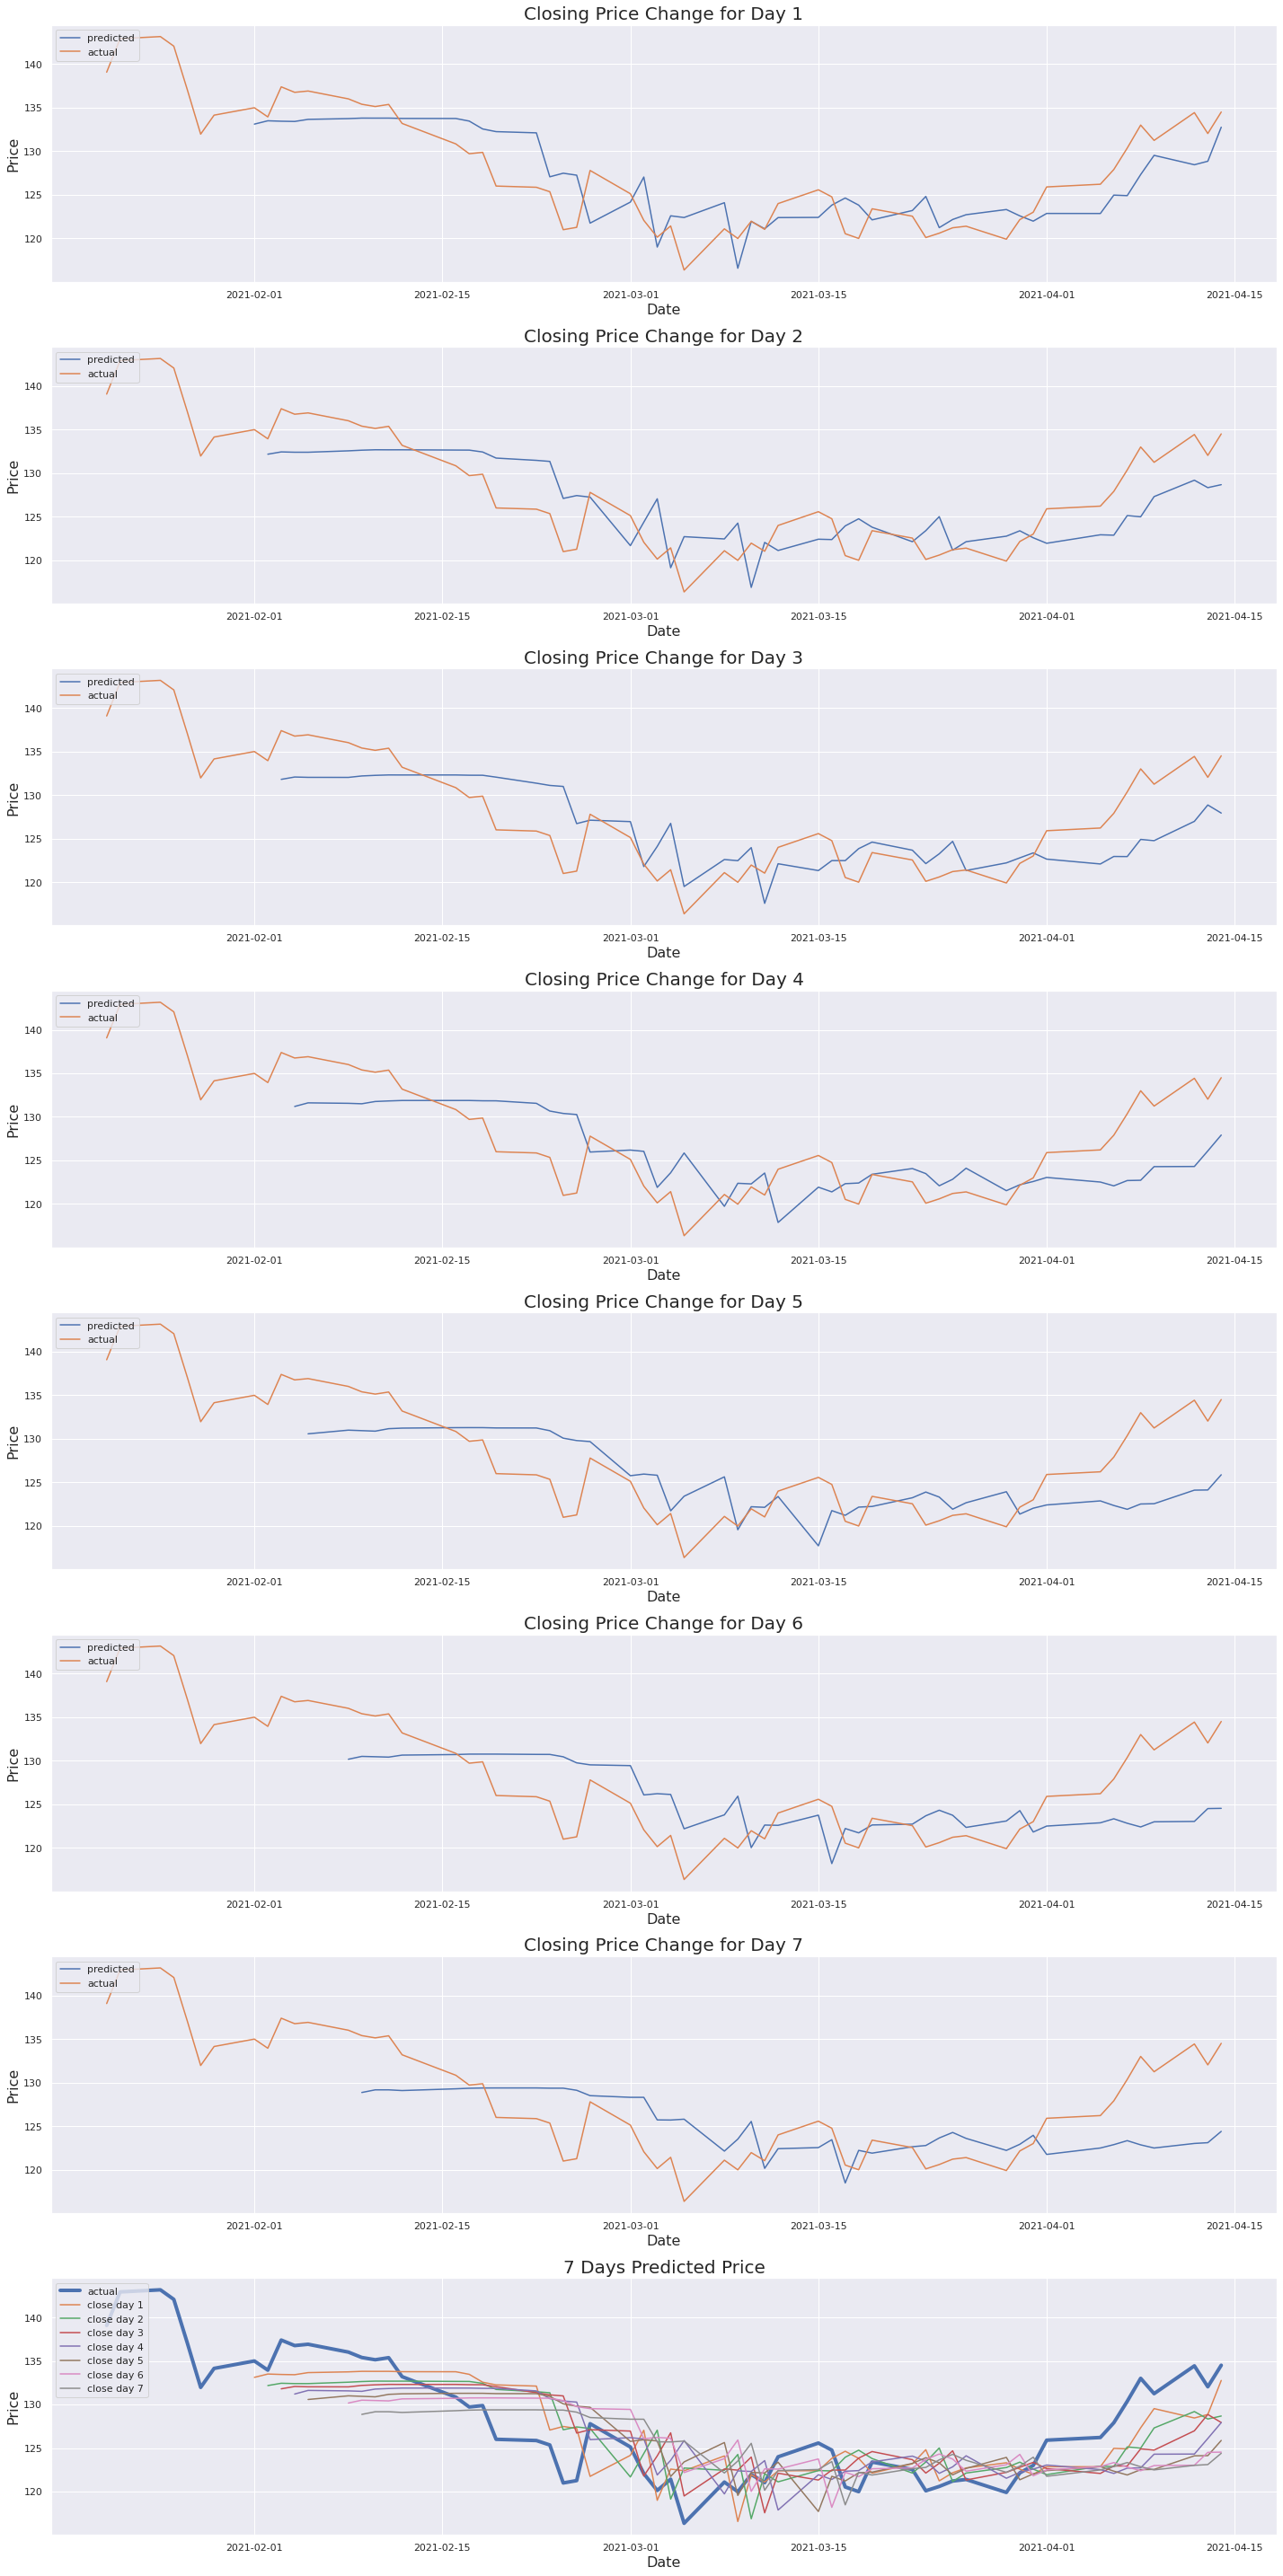

In [92]:
fig,axes=plt.subplots(8,1,figsize=(20,40))

axes[7].plot(y_test,label='actual',linewidth=4)
for i in range(0,7):
  axes[7].plot(predict_signal['close'+str(i+1)].shift(i),label='close day '+str(i+1))
  axes[7].set_xlabel('Date',size=16)
  axes[7].set_ylabel('Price',size=16)
  axes[7].set_title('7 Days Predicted Price',size=20)
  axes[7].legend(loc='upper left')

for i in range(0,7):
  axes[i].plot(predict_signal['close'+str(i+1)].shift(i),label='predicted')
  axes[i].plot(y_test,label='actual')
  axes[i].set_title('Closing Price Change for Day '+str(i+1),size=20)
  axes[i].set_xlabel('Date',size=16)
  axes[i].set_ylabel('Price',size=16)
  axes[i].legend(loc='upper left')

plt.tight_layout();
plt.savefig('/content/drive/MyDrive/image/signal_7');

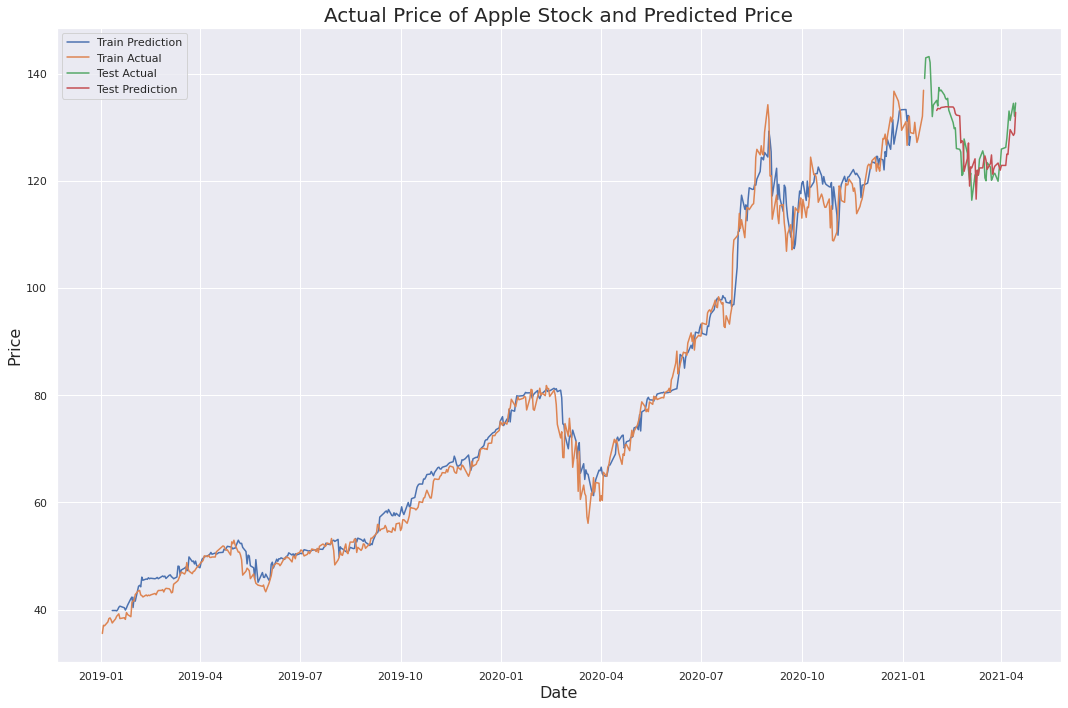

In [89]:
plt.figure(figsize=(15,10))
plt.plot(train_predict_signal['close1'],label='Train Prediction')
plt.plot(y_train,label='Train Actual')
plt.plot(y_test,label='Test Actual')
plt.plot(predict_signal['close1'],label='Test Prediction')
plt.legend(loc='upper left')
plt.xlabel('Date',fontsize=16)
plt.ylabel('Price',fontsize=16)
plt.title('Actual Price of Apple Stock and Predicted Price',size=20)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/image/signal');

## Conclusion

From this project, there are a few learning points that we could take away.

Firstly, while doing sequences to sequences prediction, there is bound to be a slight lack in the prediction reaction time of the furthest output prediction as it is based on previous trends and predicted values of the pass few days. Hence, when there is a sudden shock to price, it will take time for the model to react. Hence, when we are using these model, we should be looking for a longer term investment.

Secondly, LSTM is a slow model which would take up a lot of computational capability if feeding in large amount of data and having more complicated layers. For further development, we could consider using embedding of time to vector. This will allow more modern GPU to execute the model much more efficiently. It is hard to tune an LSTM model and despite the memory cell, it will still lose some long term memory. With the use of transformer and attention layer, it will help to retain long term dependence.

Lastly, multiple feature engineering such as Relative Strength Index (RSI), Simple Moving Average (SMA) was initially introduce but was later remove as it does not give our model any better results. However, we could try to introduce more variables to fit the model with more epochs and deeper layer. This might help us to have a better prediction. It is also difficult to tune an LSTM model as the validation loss is fluctuating a lot and EarlyStop are hard to introduce.